In [1]:
#Author: Luke Schwan
# References Tensorflow libary

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras import Sequential
from PIL import Image
import pathlib
import IPython.display as display
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Activation
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator






# import data
metadata_dir = '../metadata.csv'
image_dir ='../images/'
valid_dir ='../validation/'
imagePath = pathlib.Path(image_dir)


def getImg(name):
        return (image_dir+name)


#nn display adapted from tensorflow documentationmetadata = pd.read_csv(metadata_dir)
# what info do we have?
print(metadata.columns)

covidSubset = metadata[(metadata.finding == "COVID-19")]


#create a list of the filenames from the metadata
covidFile = list()
for item in covidSubset.filename:
        #print(item)
        covidFile.append(item)

CLASS_NAMES = metadata.finding.unique()
print(str(CLASS_NAMES))

nonCovidSubset=metadata[(metadata.finding != "COVID-19")]

metadata[(metadata.finding != "COVID-19")]=(metadata[(metadata.finding != "COVID-19")]).replace(to_replace=CLASS_NAMES, value='NONCOVID')



#create class list
CLASS_NAMES = metadata.finding.unique()


#create a list of the filenames from the metadata
nonCovid = list()
for item in nonCovidSubset.filename:
        #print(item)
        nonCovid.append(item)

num_covid_img = len(covidFile)
num_non_covid_img = len(nonCovid)
print('Number of COVID-19 Images:' + str(num_covid_img))
print('Number of Control Images:' + str(num_non_covid_img))
print('Class Names are:')
print(CLASS_NAMES)





Index(['patientid', 'offset', 'sex', 'age', 'finding', 'survival', 'intubated',
       'intubation_present', 'went_icu', 'needed_supplemental_O2', 'extubated',
       'temperature', 'pO2_saturation', 'leukocyte_count', 'neutrophil_count',
       'lymphocyte_count', 'view', 'modality', 'date', 'location', 'folder',
       'filename', 'doi', 'url', 'license', 'clinical_notes', 'other_notes',
       'Unnamed: 27'],
      dtype='object')
['COVID-19' 'ARDS' 'SARS' 'Pneumocystis' 'Streptococcus' 'No Finding'
 'Chlamydophila' 'E.Coli' 'COVID-19, ARDS' 'Klebsiella' 'Legionella']
Number of COVID-19 Images:253
Number of Control Images:76
Class Names are:
['COVID-19' 'NONCOVID']
Using TensorFlow backend.


In [2]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,zoom_range=[.8,1], brightness_range=[.5,1.1], shear_range=.5)
validation_image_generator = ImageDataGenerator(rescale=1./255, zoom_range=0.5)

#constants for the loader
BATCH_SIZE = 70
IMG_HEIGHT = 600
IMG_WIDTH = 400
IMAGE_COUNT = covidFile+nonCovid
STEPS_PER_EPOCH = np.ceil(((num_covid_img+num_non_covid_img)/BATCH_SIZE))






In [3]:
train_data_gen = image_generator.flow_from_dataframe(dataframe=metadata,target_size=(IMG_HEIGHT, IMG_WIDTH), directory=image_dir, y_col='finding', BATCH_SIZE=BATCH_SIZE,class_mode='categorical')

valid_data_gen =  validation_image_generator.flow_from_dataframe(dataframe=metadata,target_size=(IMG_HEIGHT, IMG_WIDTH), directory='../validation/', y_col='finding', BATCH_SIZE=BATCH_SIZE, class_mode='categorical')

Found 213 validated image filenames belonging to 2 classes.
Found 70 validated image filenames belonging to 2 classes.


In [4]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

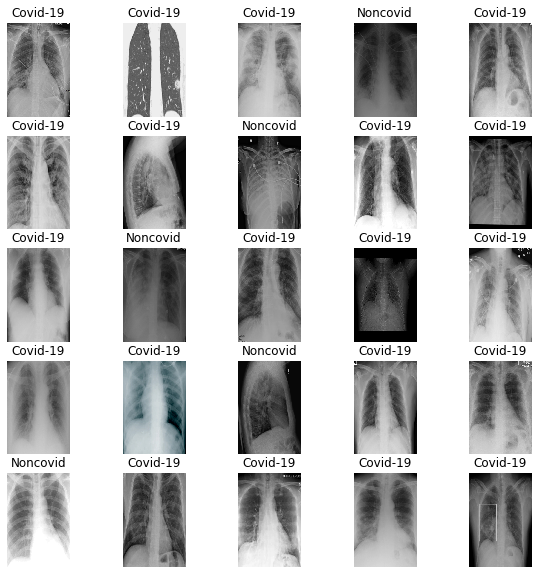

In [5]:
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

In [6]:
model = Sequential([
    Conv2D(64, 3, padding='same', activation='relu', 
           input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Dropout(0.1),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.3),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(2)
])

In [7]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=['accuracy'])
#model.load_weights('../updatedWeights.h5')

#IF YOU WANT TO LOAD PREVIOUS WEIGTH USE above


In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 600, 400, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 300, 200, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 300, 200, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 300, 200, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 150, 100, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 100, 64)      36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 75, 50, 64)        0

In [9]:
epochs = 80
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch= 213 // BATCH_SIZE,
    epochs=epochs,
    validation_data=valid_data_gen,
    validation_steps=70 // BATCH_SIZE
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 3 steps, validate for 1 steps
Epoch 1/80
3/3 [==============================] - 52s 17s/step - loss: 11.5401 - accuracy: 0.5833 - val_loss: 3.3735 - val_accuracy: 0.1875
Epoch 2/80
3/3 [==============================] - 47s 16s/step - loss: 2.1672 - accuracy: 0.5208 - val_loss: 0.5031 - val_accuracy: 0.8125
Epoch 3/80
3/3 [==============================] - 46s 15s/step - loss: 0.7635 - accuracy: 0.5521 - val_loss: 0.6428 - val_accuracy: 0.5000
Epoch 4/80
3/3 [==============================] - 44s 15s/step - loss: 0.5649 - accuracy: 0.6765 - val_loss: 0.5071 - val_accuracy: 0.8125
Epoch 5/80
3/3 [==============================] - 45s 15s/step - loss: 0.6015 - accuracy: 0.7294 - val_loss: 0.5835 - val_accuracy: 0.5000
Epoch 6/80
3/3 [==============================] - 43s 14s/step - loss: 0.6493 - accuracy: 0.5118 - val_loss: 0.5945 - val_accuracy: 0.5938

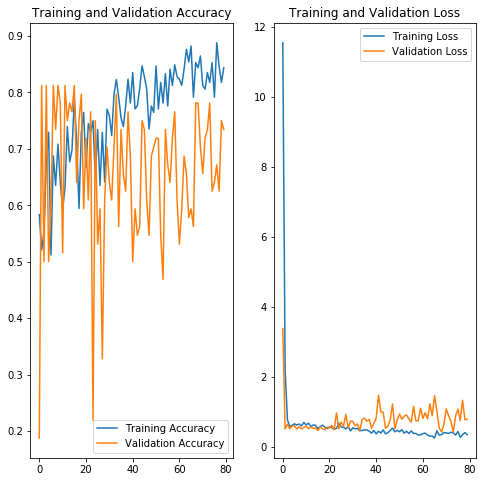

In [15]:

model.save_weights('../updatedWeights2.h5')
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [11]:
print(metadata.finding.unique())

['COVID-19' 'NONCOVID']


In [12]:

img = Image.open('./estLung.jpg')
img=img.resize((IMG_WIDTH,IMG_HEIGHT))
data = np.reshape(img,(1,IMG_HEIGHT,IMG_WIDTH,3))
preds =  model.predict(data)
print(preds)

output = model.output[:, 0]
model.layers_by_depth




[[ 497.011   -503.13898]]


AttributeError: 'Sequential' object has no attribute 'layers_by_depth'